<a href="https://colab.research.google.com/github/Masoud-Ghasemian/BERT/blob/master/Tweeter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install transformers

In [46]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [79]:
#df = pd.read_csv('train.csv', encoding = "ISO-8859-1",  names = ["target", "ids", "date", "flag", "user", "text"]) 
df = pd.read_csv('train_small.csv') 

In [80]:
df.head(5)

,Unnamed: 0,target,ids,date,flag,user,text,sentiment
0,541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
1,750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",0
2,766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,0
3,285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,0
4,705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,0


In [77]:
#df1 = df.sample(frac = 0.1)

In [78]:
#df1.to_csv('./train_small.csv')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  160000 non-null  int64 
 1   target      160000 non-null  int64 
 2   ids         160000 non-null  int64 
 3   date        160000 non-null  object
 4   flag        160000 non-null  object
 5   user        160000 non-null  object
 6   text        160000 non-null  object
 7   sentiment   160000 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 9.8+ MB


In [82]:
df.shape

(160000, 8)

In [83]:
set(df.target)

{0, 4}

In [85]:
def to_sentiment (rating):
  rating = int(rating)
  if rating ==0:
    return 0
  else:
    return 1


In [86]:
df['sentiment'] = df.target.apply(to_sentiment)

In [87]:
df.columns

Index(['Unnamed: 0', 'target', 'ids', 'date', 'flag', 'user', 'text',
       'sentiment'],
      dtype='object')

In [88]:
class_names = ['negative', 'positive']

[Text(0, 0, 'negative'), Text(0, 0, 'positive')]

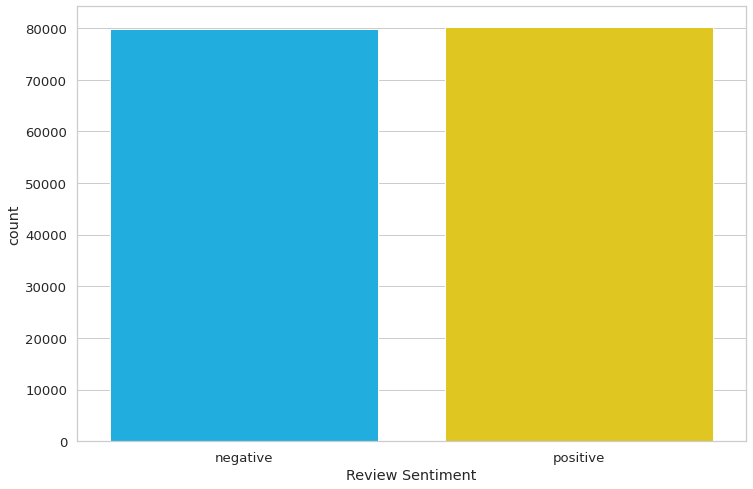

In [89]:
ax = sns.countplot(df.sentiment)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names)

In [90]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [91]:
class GPReviewDataset (Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets 
    self.tokenizer = tokenizer
    self.max_len = max_len 

  def __len__(self):
    return(len(self.reviews))

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens = True ,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt',
      truncation = True
    )

    return {
        'review_text' : review,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype = torch.long)
    }




In [92]:
MAX_LEN = 64
BATCH_SIZE = 16
EPOCHS = 3

In [93]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [94]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(144000, 8)
(8000, 8)
(8000, 8)


In [95]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews = df.text.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [96]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
bert_model = BertModel.from_pretrained('bert-base-cased')

In [97]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert =BertModel.from_pretrained('bert-base-cased' )
    self.drop = nn.Dropout(p = 0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [98]:
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [99]:
len(train_data_loader)

9000

In [100]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    _, preds =  torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    

  return correct_predictions.double() / n_examples , np.mean(losses)

In [101]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )
      _, preds =  torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())


  return correct_predictions.double() / n_examples, np.mean(losses)

In [102]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-'*10)
  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )
  print(f'Train loss = {train_loss} accuracy = {train_acc}')


  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )
  print(f'Val loss = {val_loss} accuracy = {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss = 0.3477455326732662 accuracy = 0.8499236111111111
Val loss = 0.3440309275537729 accuracy = 0.8525
Epoch 2/3
----------
Train loss = 0.2685243460610509 accuracy = 0.8919652777777778
Val loss = 0.37369833581894635 accuracy = 0.856
Epoch 3/3
----------
Train loss = 0.21200591276544664 accuracy = 0.9250069444444445
Val loss = 0.47257870008796454 accuracy = 0.856125
CPU times: user 51min 40s, sys: 10min 41s, total: 1h 2min 21s
Wall time: 1h 2min 31s


(0.0, 3.0)

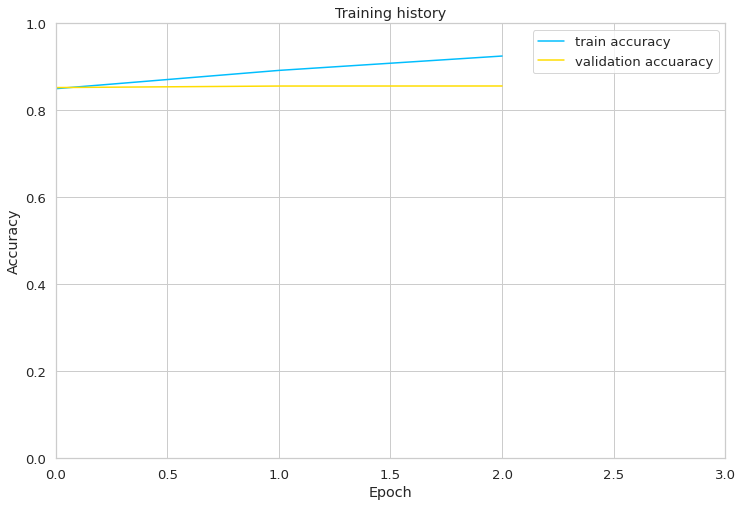

In [104]:
plt.plot(history['train_acc'], label = 'train accuracy')
plt.plot(history['val_acc'], label = 'validation accuaracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])

In [105]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.856875

In [106]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  predictions_probs = []
  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d['review_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)


      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim = 1)

      review_texts.extend(texts)
      predictions.extend(preds)
      predictions_probs.extend(outputs)
      real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      predictions_probs = torch.stack(predictions_probs).cpu()
      real_values = torch.stack(real_values).cpu()

      return review_texts, predictions, predictions_probs, real_values

In [107]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [108]:
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    negative       0.67      1.00      0.80         6
    positive       1.00      0.70      0.82        10

    accuracy                           0.81        16
   macro avg       0.83      0.85      0.81        16
weighted avg       0.88      0.81      0.81        16



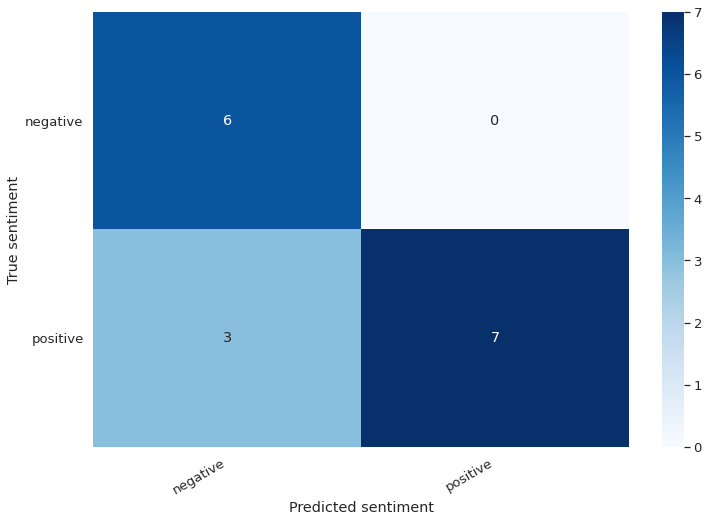

In [109]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)